In [13]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings

# Suppress warnings for a cleaner output, especially for a large dataset
warnings.filterwarnings("ignore", category=UserWarning)

# --- STEP 1: FEATURE AND TARGET ENGINEERING (UPGRADED WITH PCA) ---
def engineer_features_and_target(df, early_career_years=4, peak_career_years_start=5, peak_career_years_end=7, legend_quantile=0.7):
    """
    Engineers features from early career stats and creates a binary target
    (is_legend) based on an objective, PCA-derived peak performance score.
    This function should only be called on the training data (players with full careers).
    """
    print("Step 1: Engineering features and targets for the training set...")
    player_keys = df['player_key'].unique()
    
    # --- Part A: Objectively define "Legend" using PCA on Peak Performance ---
    print("  - Defining 'Legend' status using PCA on peak career stats...")
    peak_stats_list = []
    player_keys_with_peak = [] # This list will store keys of players with valid peak data

    # In this design, all players in `df` are training players with enough data
    for key in player_keys:
        player_stats = df[df['player_key'] == key]
        # MODIFIED: Using 'career_year' instead of 'year'
        peak_stats = player_stats[(player_stats['career_year'] >= peak_career_years_start) & (player_stats['career_year'] <= peak_career_years_end)]
        
        if peak_stats.empty:
            print(f"  - WARNING: Skipping player '{key}' from training set as they have no data in the peak window (Years {peak_career_years_start}-{peak_career_years_end}).")
            continue

        avg_peak_stats = peak_stats[['runs', 'avg', 'sr', 'dismissals']].mean().values
        peak_stats_list.append(avg_peak_stats)
        player_keys_with_peak.append(key) # Only add players with valid data

    if len(peak_stats_list) < 2:
        raise ValueError("Could not process peak stats. Need at least 2 valid players with peak career data to build the model.")

    # Scale the peak stats before applying PCA
    scaler_pca = StandardScaler()
    scaled_peak_stats = scaler_pca.fit_transform(peak_stats_list)

    # Apply PCA to find the principal component of performance
    pca = PCA(n_components=1)
    objective_peak_scores = pca.fit_transform(scaled_peak_stats).flatten()
    
    player_peak_scores = dict(zip(player_keys_with_peak, objective_peak_scores))

    legend_threshold = np.quantile(objective_peak_scores, legend_quantile)
    print(f"  - Data-Driven 'Legend' Threshold (PCA Score > {legend_quantile*100:.0f}th percentile): {legend_threshold:.2f}")

    # --- Part B: Create training features (early career) and targets (is_legend) ---
    print("  - Creating training features from early career stats...")
    features = []
    targets = []

    # MODIFIED: Loop over only the players who had valid peak data
    for key in player_keys_with_peak:
        player_stats = df[df['player_key'] == key]
        # MODIFIED: Using 'career_year' instead of 'year'
        early_stats = player_stats[player_stats['career_year'] <= early_career_years]
        feature_vector = [
            early_stats['runs'].mean(),
            early_stats['avg'].mean(),
            early_stats['sr'].mean(),
            early_stats['dismissals'].mean()
        ]
        features.append(feature_vector)

        current_peak_score = player_peak_scores[key]
        targets.append(1 if current_peak_score >= legend_threshold else 0)
    
    print("Step 1 Complete.\n")
    return np.array(features), np.array(targets)


# --- STEP 2: PREDICTION ---
def predict_legend_probability(model, scaler, new_keeper_stats, early_career_years=4):
    """
    Predicts the probability of a new keeper becoming a legend.
    """
    # MODIFIED: Using 'career_year' instead of 'year'
    if len(new_keeper_stats) < early_career_years:
        return None

    early_stats = new_keeper_stats[new_keeper_stats['career_year'] <= early_career_years]
    features = [[
        early_stats['runs'].mean(),
        early_stats['avg'].mean(),
        early_stats['sr'].mean(),
        early_stats['dismissals'].mean()
    ]]
    
    scaled_features = scaler.transform(features)
    probability = model.predict_proba(scaled_features)[0][1]
    return probability

# --- ADDED: MODEL VALIDATION FUNCTION ---
def validate_model(X, y):
    """
    Performs backtesting on a hold-out set to validate model credibility.
    """
    print("--- Model Validation Report ---")
    if len(X) < 5:
        print("Validation skipped: Not enough historical data to create a meaningful test set.")
        return

    # Split the historical data into a training set and a test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
    
    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train a new model just on the training portion
    validation_model = LogisticRegression(random_state=42)
    validation_model.fit(X_train_scaled, y_train)

    # Make predictions on the unseen test set
    y_pred = validation_model.predict(X_test_scaled)

    # Print the credibility metrics
    print(f"Validation Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f}%")
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['Not a Legend', 'Legend']))
    print("---------------------------------\n")

# --- ADDED: FUNCTION TO GET CUSTOM PLAYER DATA ---
def get_custom_player_data():
    """
    Prompts the user to manually enter stats for a custom player.
    """
    print("\n--- Enter Custom Player Data ---")
    name = input("Enter the player's name: ")
    custom_stats = []
    for i in range(1, 5): # Get stats for the first 4 years
        print(f"\nEnter stats for Career Year {i}:")
        while True:
            try:
                runs = float(input(f"  Total Runs for Year {i}: "))
                avg = float(input(f"  Batting Average for Year {i}: "))
                sr = float(input(f"  Strike Rate for Year {i}: "))
                dismissals = float(input(f"  Dismissals for Year {i}: "))
                custom_stats.append({
                    'player_key': 'custom', 'name': name, 'career_year': i,
                    'runs': runs, 'avg': avg, 'sr': sr, 'dismissals': dismissals
                })
                break
            except ValueError:
                print("Invalid input. Please enter numbers only.")
    
    return pd.DataFrame(custom_stats), name


# --- MAIN EXECUTION REFACTORED INTO A FUNCTION ---
def main():
    """
    Main function to run the full prediction pipeline.
    """
    print("--- Wicketkeeper Legend Predictor (PCA-based Classification) ---")
    
    try:
        data_df = pd.read_csv('/kaggle/input/keeper-dataset/keeper_data.csv')
        print("Successfully loaded 'keeper_data.csv'.")
    except FileNotFoundError:
        print("\nERROR: 'keeper_data.csv' not found.")
        print("Please make sure the CSV file is in the same directory as this script.")
        return

    # --- ADDED: DATA PRE-PROCESSING STEP ---
    # Convert the calendar year into the nth year of a player's career.
    print("\nProcessing data to calculate career years...")
    data_df['career_year'] = data_df.groupby('player_key')['year'].rank(method='dense').astype(int)
    print("Data processing complete.\n")

    # --- Separate players for training and prediction ---
    min_years_for_training = 5 # A player needs at least 5 years of data to be considered for training
    # MODIFIED: Using 'career_year' instead of 'year'
    player_year_counts = data_df.groupby('player_key')['career_year'].max()
    
    train_player_keys = player_year_counts[player_year_counts >= min_years_for_training].index
    train_df = data_df[data_df['player_key'].isin(train_player_keys)]
    
    if len(train_df['player_key'].unique()) < 2:
        print(f"\nERROR: Not enough historical player data (with {min_years_for_training}+ years) to train the model.")
        return

    try:
        X, y = engineer_features_and_target(train_df)
    except ValueError as e:
        print(f"\nERROR: Could not build training data. Reason: {e}")
        return

    if len(np.unique(y)) < 2:
        print("\nERROR: Cannot train the model.")
        print("The training data contains only one class (e.g., all players are classified as 'legends' or 'non-legends').")
        print("Please add more diverse player data to the CSV file.")
        return

    # --- ADDED: Run validation before training the final model ---
    validate_model(X, y)

    print("Step 2: Scaling all available historical features for final model...")
    scaler_train = StandardScaler()
    X_scaled = scaler_train.fit_transform(X)
    print("Scaling complete.\n")

    print("Step 3: Training final classification model on all historical data...")
    model = LogisticRegression(random_state=42)
    model.fit(X_scaled, y)
    print("Model training complete.\n")

    # --- MODIFIED: ADDED OPTION FOR CUSTOM PLAYER INPUT ---
    print("How would you like to make a prediction?")
    print("  1: Choose a player from the dataset")
    print("  2: Enter stats for a custom player")

    mode_choice = ''
    while mode_choice not in ['1', '2']:
        mode_choice = input("Enter your choice (1 or 2): ")

    if mode_choice == '1':
        # --- MODIFIED: Allow prediction for ANY player in the dataset ---
        players_to_predict_list = data_df[['player_key', 'name']].drop_duplicates().values
        
        print("\nPlease select a wicketkeeper to predict their 'Legend' probability:")
        for i, (key, name) in enumerate(players_to_predict_list):
            print(f"  {i+1}: {name}")

        choice = -1
        while choice < 1 or choice > len(players_to_predict_list):
            try:
                raw_choice = input(f"\nEnter the number of your choice (1-{len(players_to_predict_list)}): ")
                choice = int(raw_choice)
                if choice < 1 or choice > len(players_to_predict_list):
                    print("Invalid choice. Please try again.")
            except ValueError:
                print("Invalid input. Please enter a number.")
                
        selected_key, selected_name = players_to_predict_list[choice - 1]
        keeper_to_predict_stats = data_df[data_df['player_key'] == selected_key]

    else: # mode_choice == '2'
        keeper_to_predict_stats, selected_name = get_custom_player_data()

    
    print(f"\nStep 4: Making a prediction for '{selected_name}'...")
    legend_probability = predict_legend_probability(model, scaler_train, keeper_to_predict_stats)

    print("\n--- Prediction Result ---")
    print(f"Analyzing: {selected_name}")
    if legend_probability is not None:
        print(f"Predicted Probability of Achieving 'Legend' Status: {legend_probability * 100:.1f}%")
        print("\nNote: This probability is based on comparing the player's early career stats to the patterns of historical greats, as determined by PCA.")
    else:
        print(f"Could not make a prediction for {selected_name}. Not enough career data available (requires at least 4 years).")
    print("\n--- Script Finished ---")

if __name__ == "__main__":
    main()


--- Wicketkeeper Legend Predictor (PCA-based Classification) ---
Successfully loaded 'keeper_data.csv'.

Processing data to calculate career years...
Data processing complete.

Step 1: Engineering features and targets for the training set...
  - Defining 'Legend' status using PCA on peak career stats...
  - Data-Driven 'Legend' Threshold (PCA Score > 70th percentile): 0.29
  - Creating training features from early career stats...
Step 1 Complete.

--- Model Validation Report ---
Validation Accuracy: 85.71%

Confusion Matrix:
[[5 0]
 [1 1]]

Classification Report:
              precision    recall  f1-score   support

Not a Legend       0.83      1.00      0.91         5
      Legend       1.00      0.50      0.67         2

    accuracy                           0.86         7
   macro avg       0.92      0.75      0.79         7
weighted avg       0.88      0.86      0.84         7

---------------------------------

Step 2: Scaling all available historical features for final model...

Enter your choice (1 or 2):  1



Please select a wicketkeeper to predict their 'Legend' probability:
  1: MS Dhoni
  2: Adam Gilchrist
  3: Mark Boucher
  4: Kumar Sangakkara
  5: Ian Healy
  6: Rod Marsh
  7: Brendon McCullum
  8: Brad Haddin
  9: BJ Watling
  10: Matt Prior
  11: Rishabh Pant
  12: Mohammad Rizwan
  13: Jos Buttler
  14: Quinton de Kock
  15: Mushfiqur Rahim
  16: Wriddhiman Saha
  17: Alex Carey
  18: Tom Latham
  19: Sarfaraz Ahmed
  20: Moin Khan
  21: Alec Stewart
  22: Jeff Dujon
  23: Alan Knott
  24: Dave Richardson
  25: Nayan Mongia
  26: Kamran Akmal
  27: Niroshan Dickwella
  28: Litton Das
  29: Shai Hope
  30: KL Rahul



Enter the number of your choice (1-30):  2



Step 4: Making a prediction for 'Adam Gilchrist'...

--- Prediction Result ---
Analyzing: Adam Gilchrist
Predicted Probability of Achieving 'Legend' Status: 55.2%

Note: This probability is based on comparing the player's early career stats to the patterns of historical greats, as determined by PCA.

--- Script Finished ---


--- Wicketkeeper Analysis Tool ---
Successfully loaded 'keeper_data.csv'.

Processing data to calculate career years...
Data processing complete.

Optimizing performance score weights using PCA...
PCA-Optimized Weights Found:
  - Runs: 0.31
  - Avg: 0.28
  - Sr: 0.15
  - Dismissals: 0.27

--- Career Trajectory Comparison ---

Select the metric you want to compare:
  1: PCA-Optimized Performance Score
  2: Total Runs per Year
  3: Batting Average per Year
  4: Strike Rate per Year
  5: Dismissals per Year


Enter your choice (1-5):  1



Select players to compare (enter numbers separated by commas, e.g., 1,5,10):
  1: MS Dhoni
  2: Adam Gilchrist
  3: Mark Boucher
  4: Kumar Sangakkara
  5: Ian Healy
  6: Rod Marsh
  7: Brendon McCullum
  8: Brad Haddin
  9: BJ Watling
  10: Matt Prior
  11: Rishabh Pant
  12: Mohammad Rizwan
  13: Jos Buttler
  14: Quinton de Kock
  15: Mushfiqur Rahim
  16: Wriddhiman Saha
  17: Alex Carey
  18: Tom Latham
  19: Sarfaraz Ahmed
  20: Moin Khan
  21: Alec Stewart
  22: Jeff Dujon
  23: Alan Knott
  24: Dave Richardson
  25: Nayan Mongia
  26: Kamran Akmal
  27: Niroshan Dickwella
  28: Litton Das
  29: Shai Hope
  30: KL Rahul



Enter player numbers:  1,2


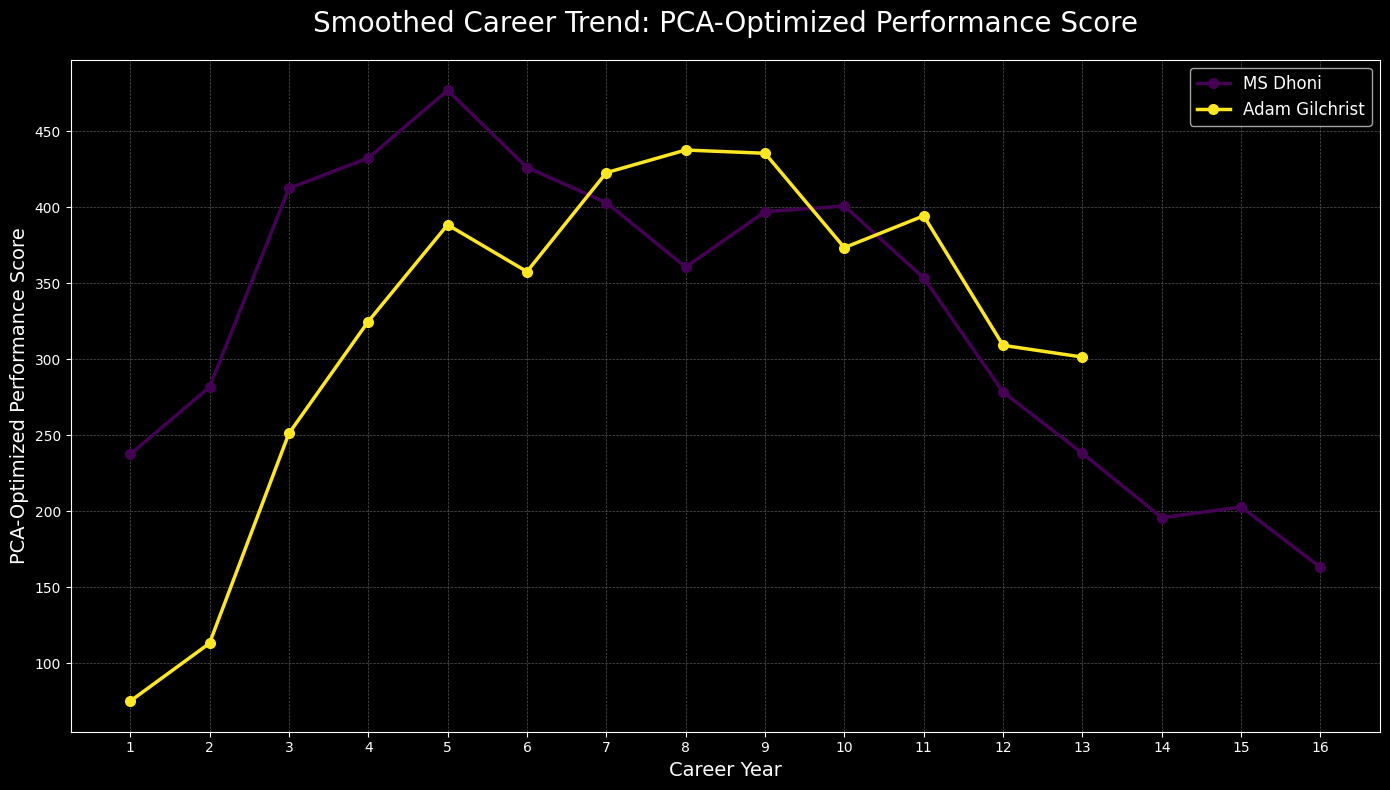


--- Script Finished ---


In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import warnings

# Suppress warnings for a cleaner output
warnings.filterwarnings("ignore", category=UserWarning)

# --- NEW: PCA-BASED WEIGHT OPTIMIZATION ---
def get_pca_weights(df):
    """
    Uses PCA to find the optimal, data-driven weights for the performance score.
    """
    print("\nOptimizing performance score weights using PCA...")
    
    # Select the core statistical columns
    stats_df = df[['runs', 'avg', 'sr', 'dismissals']]
    
    # Scale the data before applying PCA
    scaler = StandardScaler()
    scaled_stats = scaler.fit_transform(stats_df)
    
    # Apply PCA to find the single most important component of performance
    pca = PCA(n_components=1)
    pca.fit(scaled_stats)
    
    # The "loadings" of the first component are our new weights
    # We use the absolute value as we only care about the magnitude of contribution
    raw_weights = np.abs(pca.components_[0])
    
    # Normalize the weights so they sum to 1
    normalized_weights = raw_weights / np.sum(raw_weights)
    
    weights = {
        'runs': normalized_weights[0],
        'avg': normalized_weights[1],
        'sr': normalized_weights[2],
        'dismissals': normalized_weights[3]
    }
    
    print("PCA-Optimized Weights Found:")
    for stat, weight in weights.items():
        print(f"  - {stat.capitalize()}: {weight:.2f}")
        
    return weights

# --- MODIFIED VISUALIZATION SCORE ---
def calculate_visual_score(row, weights):
    """Creates a performance score using the provided weights."""
    # This function now uses the weights calculated by PCA
    score = (
        weights['runs'] * row['runs'] +
        weights['avg'] * row['avg'] +
        weights['sr'] * row['sr'] +
        weights['dismissals'] * row['dismissals']
    )
    return score

# --- GRAPHICAL COMPARISON FUNCTION ---
def run_graphical_comparison(df, weights):
    """
    Allows the user to select multiple players and a metric to plot their career trajectories.
    """
    print("\n--- Career Trajectory Comparison ---")
    
    # --- MODIFIED: ADD METRIC SELECTION ---
    print("\nSelect the metric you want to compare:")
    metrics = {
        '1': ('visual_score', 'PCA-Optimized Performance Score'),
        '2': ('runs', 'Total Runs per Year'),
        '3': ('avg', 'Batting Average per Year'),
        '4': ('sr', 'Strike Rate per Year'),
        '5': ('dismissals', 'Dismissals per Year')
    }
    for key, (metric_name, desc) in metrics.items():
        print(f"  {key}: {desc}")

    metric_choice = ''
    while metric_choice not in metrics:
        metric_choice = input("Enter your choice (1-5): ")
    
    selected_metric, y_label = metrics[metric_choice]

    # Calculate the visual score only if it's selected
    if selected_metric == 'visual_score':
        # Pass the optimized weights to the calculation function
        df['visual_score'] = df.apply(lambda row: calculate_visual_score(row, weights), axis=1)
    
    all_players_list = df[['player_key', 'name']].drop_duplicates().values
    
    print("\nSelect players to compare (enter numbers separated by commas, e.g., 1,5,10):")
    for i, (key, name) in enumerate(all_players_list):
        print(f"  {i+1}: {name}")
    
    selected_indices = []
    while not selected_indices:
        try:
            raw_input = input("\nEnter player numbers: ")
            if not raw_input.strip():
                print("Please enter at least one number.")
                continue
            selected_indices = [int(i.strip()) - 1 for i in raw_input.split(',')]
            if not all(0 <= i < len(all_players_list) for i in selected_indices):
                print("Invalid selection. Please enter numbers from the list.")
                selected_indices = []
        except (ValueError, IndexError):
            print("Invalid input. Please enter numbers separated by commas.")
            selected_indices = []

    # --- Plotting ---
    plt.style.use('dark_background')
    fig, ax = plt.subplots(figsize=(14, 8))
    
    max_len = 0
    colors = plt.cm.viridis(np.linspace(0, 1, len(selected_indices)))

    for i, index in enumerate(selected_indices):
        player_key, player_name = all_players_list[index]
        player_df = df[df['player_key'] == player_key].copy() # Use .copy() to avoid SettingWithCopyWarning
        
        # --- ADDED: Calculate the moving average to smooth the line ---
        # A 3-year window is a good balance for smoothing.
        # min_periods=1 ensures the line starts from the first year.
        player_df['smoothed_metric'] = player_df[selected_metric].rolling(window=3, min_periods=1, center=True).mean()

        if len(player_df) > max_len:
            max_len = len(player_df)
            
        ax.plot(player_df['career_year'], player_df['smoothed_metric'], 'o-', label=player_name, linewidth=2.5, markersize=7, color=colors[i])

    # --- Styling the plot ---
    # MODIFIED: Updated title to reflect the smoothed trend
    ax.set_title(f"Smoothed Career Trend: {y_label}", fontsize=20, pad=20, color='white')
    ax.set_xlabel("Career Year", fontsize=14, color='white')
    ax.set_ylabel(y_label, fontsize=14, color='white')
    ax.grid(True, linestyle='--', linewidth=0.5, color='#555555')
    ax.legend(fontsize=12)
    
    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')
    ax.set_xticks(range(1, max_len + 1))
    
    fig.tight_layout()
    plt.show()

# --- MAIN EXECUTION ---
def main():
    """
    Main function to load data and run the comparison tool.
    """
    print("--- Wicketkeeper Analysis Tool ---")
    try:
        data_df = pd.read_csv('/kaggle/input/keeper-dataset/keeper_data.csv')
        print("Successfully loaded 'keeper_data.csv'.")
    except FileNotFoundError:
        print("\nERROR: 'keeper_data.csv' not found.")
        print("Please make sure the CSV file is in the same directory as this script.")
        return

    print("\nProcessing data to calculate career years...")
    data_df['career_year'] = data_df.groupby('player_key')['year'].rank(method='dense').astype(int)
    print("Data processing complete.")

    # Get the data-driven weights first
    optimized_weights = get_pca_weights(data_df)

    # Pass the weights to the comparison tool
    run_graphical_comparison(data_df, optimized_weights)

    print("\n--- Script Finished ---")

if __name__ == "__main__":
    main()
